# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn.over_sampling import SMOTE, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [2]:
df = pd.read_csv('K85_matched.csv')

In [3]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [4]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA    MELD  \
0  c2739456-8064-485c-874a-2b509cbceb29    0          1    3      0   7.000   
1  9cc31c1f-e2f8-45d7-9f4d-cf26d4d6aa79    1          0    4      0  18.000   
2  05d95432-68e9-41b3-9137-f95f7ab271ad    1          1   10      0  23.158   
3  a022663e-1157-4d88-97a7-883147baf449    0          0    1      3  18.000   
4  f1d25465-1f26-438f-a0a5-9f3324c12fb2    0          1    6      0  31.904   

   SEWS  propensity_score  propensity_logit  albumin_24hrs  \
0     0          0.302882         -0.833612              1   
1     2          0.784405          1.291525              1   
2     2          0.960440          3.189567              1   
3    10          0.944370          2.831793              1   
4     0          0.903506          2.236798              1   

                               personid   LOS_days  90_day_mortality  \
0  0ea434c2-6ee3-459a-9df6-9c5806f64dbe  33.625000                 0   
1  0ef670bf-6e21-441c-8949-1076d3763447  12.979167                 0   
2  205e66e8-d799-4795-8cc6-c2ce865209d9   5.733333                 0   
3  24ace82f-0d96-4705-ae44-01edc2ae82b0   4.890972                 0   
4  2d1b6054-8fa5-40fd-b42a-5648a9b5b133   7.732581                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 1.0                  10             1.0        1  
1                 1.0                  67             2.0        1  
2                 1.0                  23             2.0        1  
3                 1.0                  52             1.0        1  
4                 0.0                  83             1.0        1

In [5]:
df.shape

(3134, 17)

## Select Only Patients Who Lived (Removing Patients in 0 Class Who Died)

In [6]:
df = df.loc[df['90_day_mortality'] == 0]

In [7]:
df.shape

(2455, 17)

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [8]:
ra_90d_a24 = df[df['albumin_24hrs'] == 1]['90_day_readmission'].value_counts()
print(ra_90d_a24)

0.0    646
1.0    497
Name: 90_day_readmission, dtype: int64


In [9]:
def binary_pct(var):
    pct = (var[1]/(var[1]+var[0])) * 100
    return pct

binary_pct(ra_90d_a24)

43.48206474190726

In [10]:
ra_90d = df[df['albumin_24hrs'] == 0]['90_day_readmission'].value_counts()
print(ra_90d)

0.0    779
1.0    533
Name: 90_day_readmission, dtype: int64


In [11]:
binary_pct(ra_90d)

40.625

In [13]:
df.drop(columns=['encounterid', 'personid', 'propensity_score', 'propensity_logit', 'albumin', 'albumin_timing'], inplace=True)

In [14]:
df.drop(columns=['90_day_mortality', 'LOS_days', 'hospital_free_days'], inplace=True)

In [15]:
# remove variables

# df.drop(columns=['mass_transfusion', 'anemia_status', 'qSOFA', 'hemorrhagic', 'bl_albumin_value', 'SAPS'], inplace=True)
# df.drop(columns=['qSOFA', 'bl_albumin_value', 'SAPS'], inplace=True)

In [16]:
df.describe()

ICU    Cirrhosis          CCI        qSOFA         MELD  \
count  2455.000000  2455.000000  2455.000000  2455.000000  2455.000000   
mean      0.328717     0.456212     3.692872     0.745825    19.626086   
std       0.469843     0.498180     2.758437     0.814346     8.752618   
min       0.000000     0.000000     0.000000     0.000000     6.000000   
25%       0.000000     0.000000     1.000000     0.000000    12.000000   
50%       0.000000     0.000000     3.000000     1.000000    20.000000   
75%       1.000000     1.000000     5.000000     1.000000    25.694500   
max       1.000000     1.000000    15.000000     3.000000    40.000000   

              SEWS  albumin_24hrs  90_day_readmission  
count  2455.000000    2455.000000         2455.000000  
mean      1.583707       0.465580            0.419552  
std       1.841803       0.498916            0.493586  
min       0.000000       0.000000            0.000000  
25%       0.000000       0.000000            0.000000  
50%       1.000000       0.000000            0.000000  
75%       2.000000       1.000000            1.000000  
max      10.000000       1.000000            1.000000

In [17]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [18]:
# establish target feature, LOS_days, as y feature
y = df['90_day_readmission']
# drop target feature from features dataframe
X = df.drop(columns = ['90_day_readmission'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [19]:
cols

Index(['ICU', 'Cirrhosis', 'CCI', 'qSOFA', 'MELD', 'SEWS', 'albumin_24hrs'], dtype='object')

## Standardize Data

In [20]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [21]:
X.head()

ICU  Cirrhosis  CCI  qSOFA    MELD  SEWS  albumin_24hrs
0    0          1    3      0   7.000     0              1
1    1          0    4      0  18.000     2              1
2    1          1   10      0  23.158     2              1
3    0          0    1      3  18.000    10              1
4    0          1    6      0  31.904     0              1

## Train Test Split

In [22]:
# cat_feats = [0, 1, 3, 4, 5]
# cat_feats = [0, 1, 2, 3, 5, 6, 7, 8]
cat_feats = [0, 1, 3, 5, 6]

sm = SMOTENC(random_state=42, categorical_features = cat_feats)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [23]:
#sm = SMOTEN(random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [24]:
y_train.value_counts()

0.0    1134
1.0    1134
Name: 90_day_readmission, dtype: int64

In [25]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [26]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: ICU Score: 0.00854
Feature: Cirrhosis Score: 0.19278
Feature: CCI Score: 0.00251
Feature: qSOFA Score: 0.01356
Feature: MELD Score: -0.00524
Feature: SEWS Score: -0.02540
Feature: albumin_24hrs Score: 0.04747


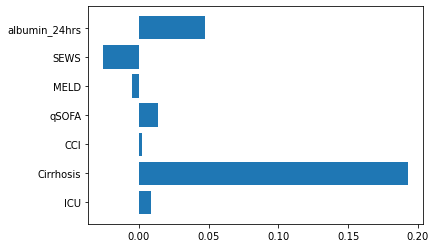

In [27]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

               Importance
Cirrhosis        1.212620
albumin_24hrs    1.048618
qSOFA            1.013657
ICU              1.008581
CCI              1.002511
MELD             0.994769
SEWS             0.974925


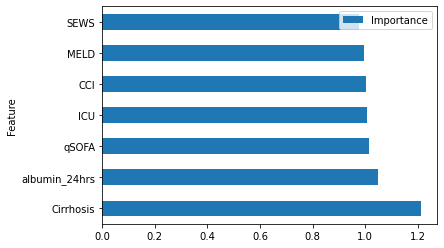

In [28]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [29]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [30]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[632 502]
 [519 615]]


In [31]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.55      0.56      0.55      1134
         1.0       0.55      0.54      0.55      1134

    accuracy                           0.55      2268
   macro avg       0.55      0.55      0.55      2268
weighted avg       0.55      0.55      0.55      2268



In [32]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[150 141]
 [ 96 104]]


In [33]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.61      0.52      0.56       291
         1.0       0.42      0.52      0.47       200

    accuracy                           0.52       491
   macro avg       0.52      0.52      0.51       491
weighted avg       0.53      0.52      0.52       491



## 1: Decision Tree (Max Depth=3)

In [34]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=3)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Feature: ICU Score: 0.18348
Feature: Cirrhosis Score: 0.00000
Feature: CCI Score: 0.00000
Feature: qSOFA Score: 0.46403
Feature: MELD Score: 0.29045
Feature: SEWS Score: 0.06204
Feature: albumin_24hrs Score: 0.00000


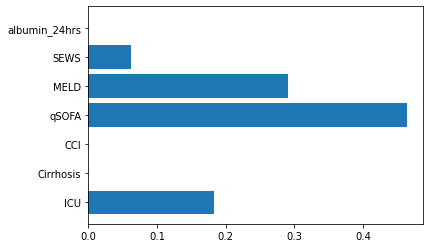

In [90]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [91]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [305]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2509 3118]
 [1524 4103]]


In [306]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.62      0.45      0.52      5627
           1       0.57      0.73      0.64      5627

    accuracy                           0.59     11254
   macro avg       0.60      0.59      0.58     11254
weighted avg       0.60      0.59      0.58     11254



In [307]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[602 797]
 [239 440]]


In [308]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.72      0.43      0.54      1399
           1       0.36      0.65      0.46       679

    accuracy                           0.50      2078
   macro avg       0.54      0.54      0.50      2078
weighted avg       0.60      0.50      0.51      2078



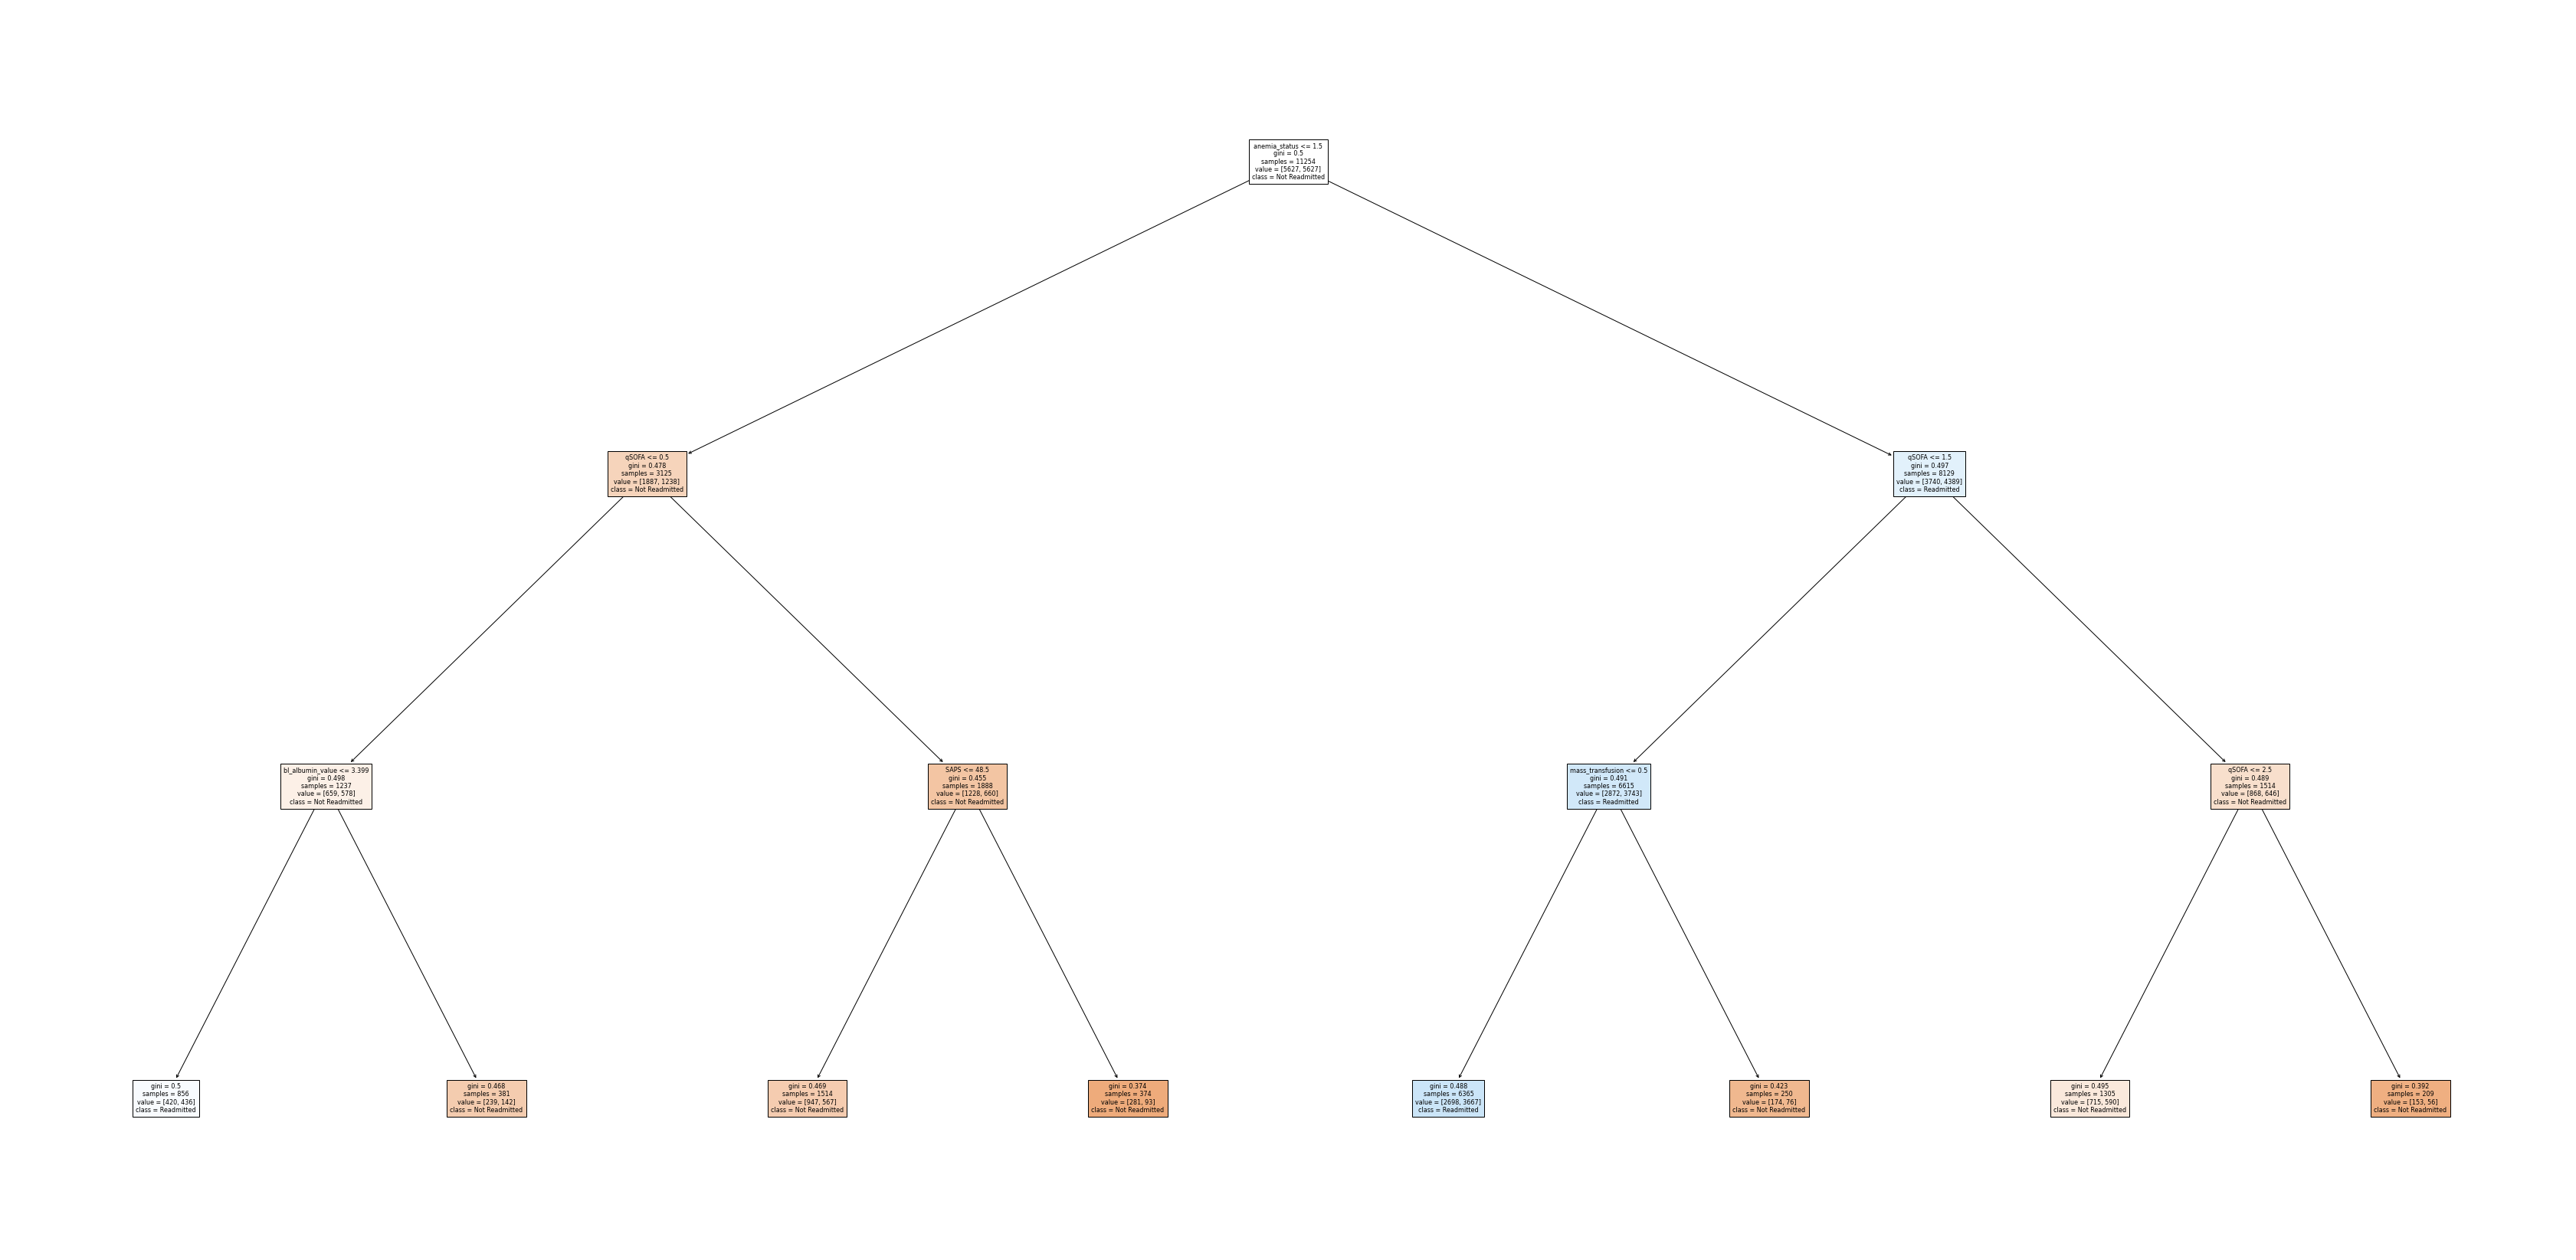

In [309]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [246]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('90DRA_DT_D3_NCBL.png')

True

## 2: Decision Tree (Max Depth=4)

In [310]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=4)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

Feature: ICU Score: 0.00000
Feature: mass_transfusion Score: 0.12502
Feature: total_transfusions Score: 0.01444
Feature: anemia_status Score: 0.32743
Feature: CCI Score: 0.01907
Feature: bl_albumin_value Score: 0.11488
Feature: qSOFA Score: 0.28297
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.00000
Feature: hemorrhagic Score: 0.07392
Feature: SAPS Score: 0.04226
Feature: albumin_24hrs Score: 0.00000


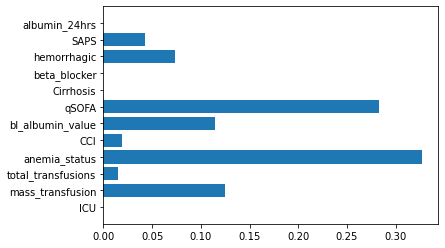

In [311]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [312]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [313]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2904 2723]
 [1860 3767]]


In [314]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56      5627
           1       0.58      0.67      0.62      5627

    accuracy                           0.59     11254
   macro avg       0.60      0.59      0.59     11254
weighted avg       0.60      0.59      0.59     11254



In [315]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[711 688]
 [287 392]]


In [316]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.71      0.51      0.59      1399
           1       0.36      0.58      0.45       679

    accuracy                           0.53      2078
   macro avg       0.54      0.54      0.52      2078
weighted avg       0.60      0.53      0.55      2078



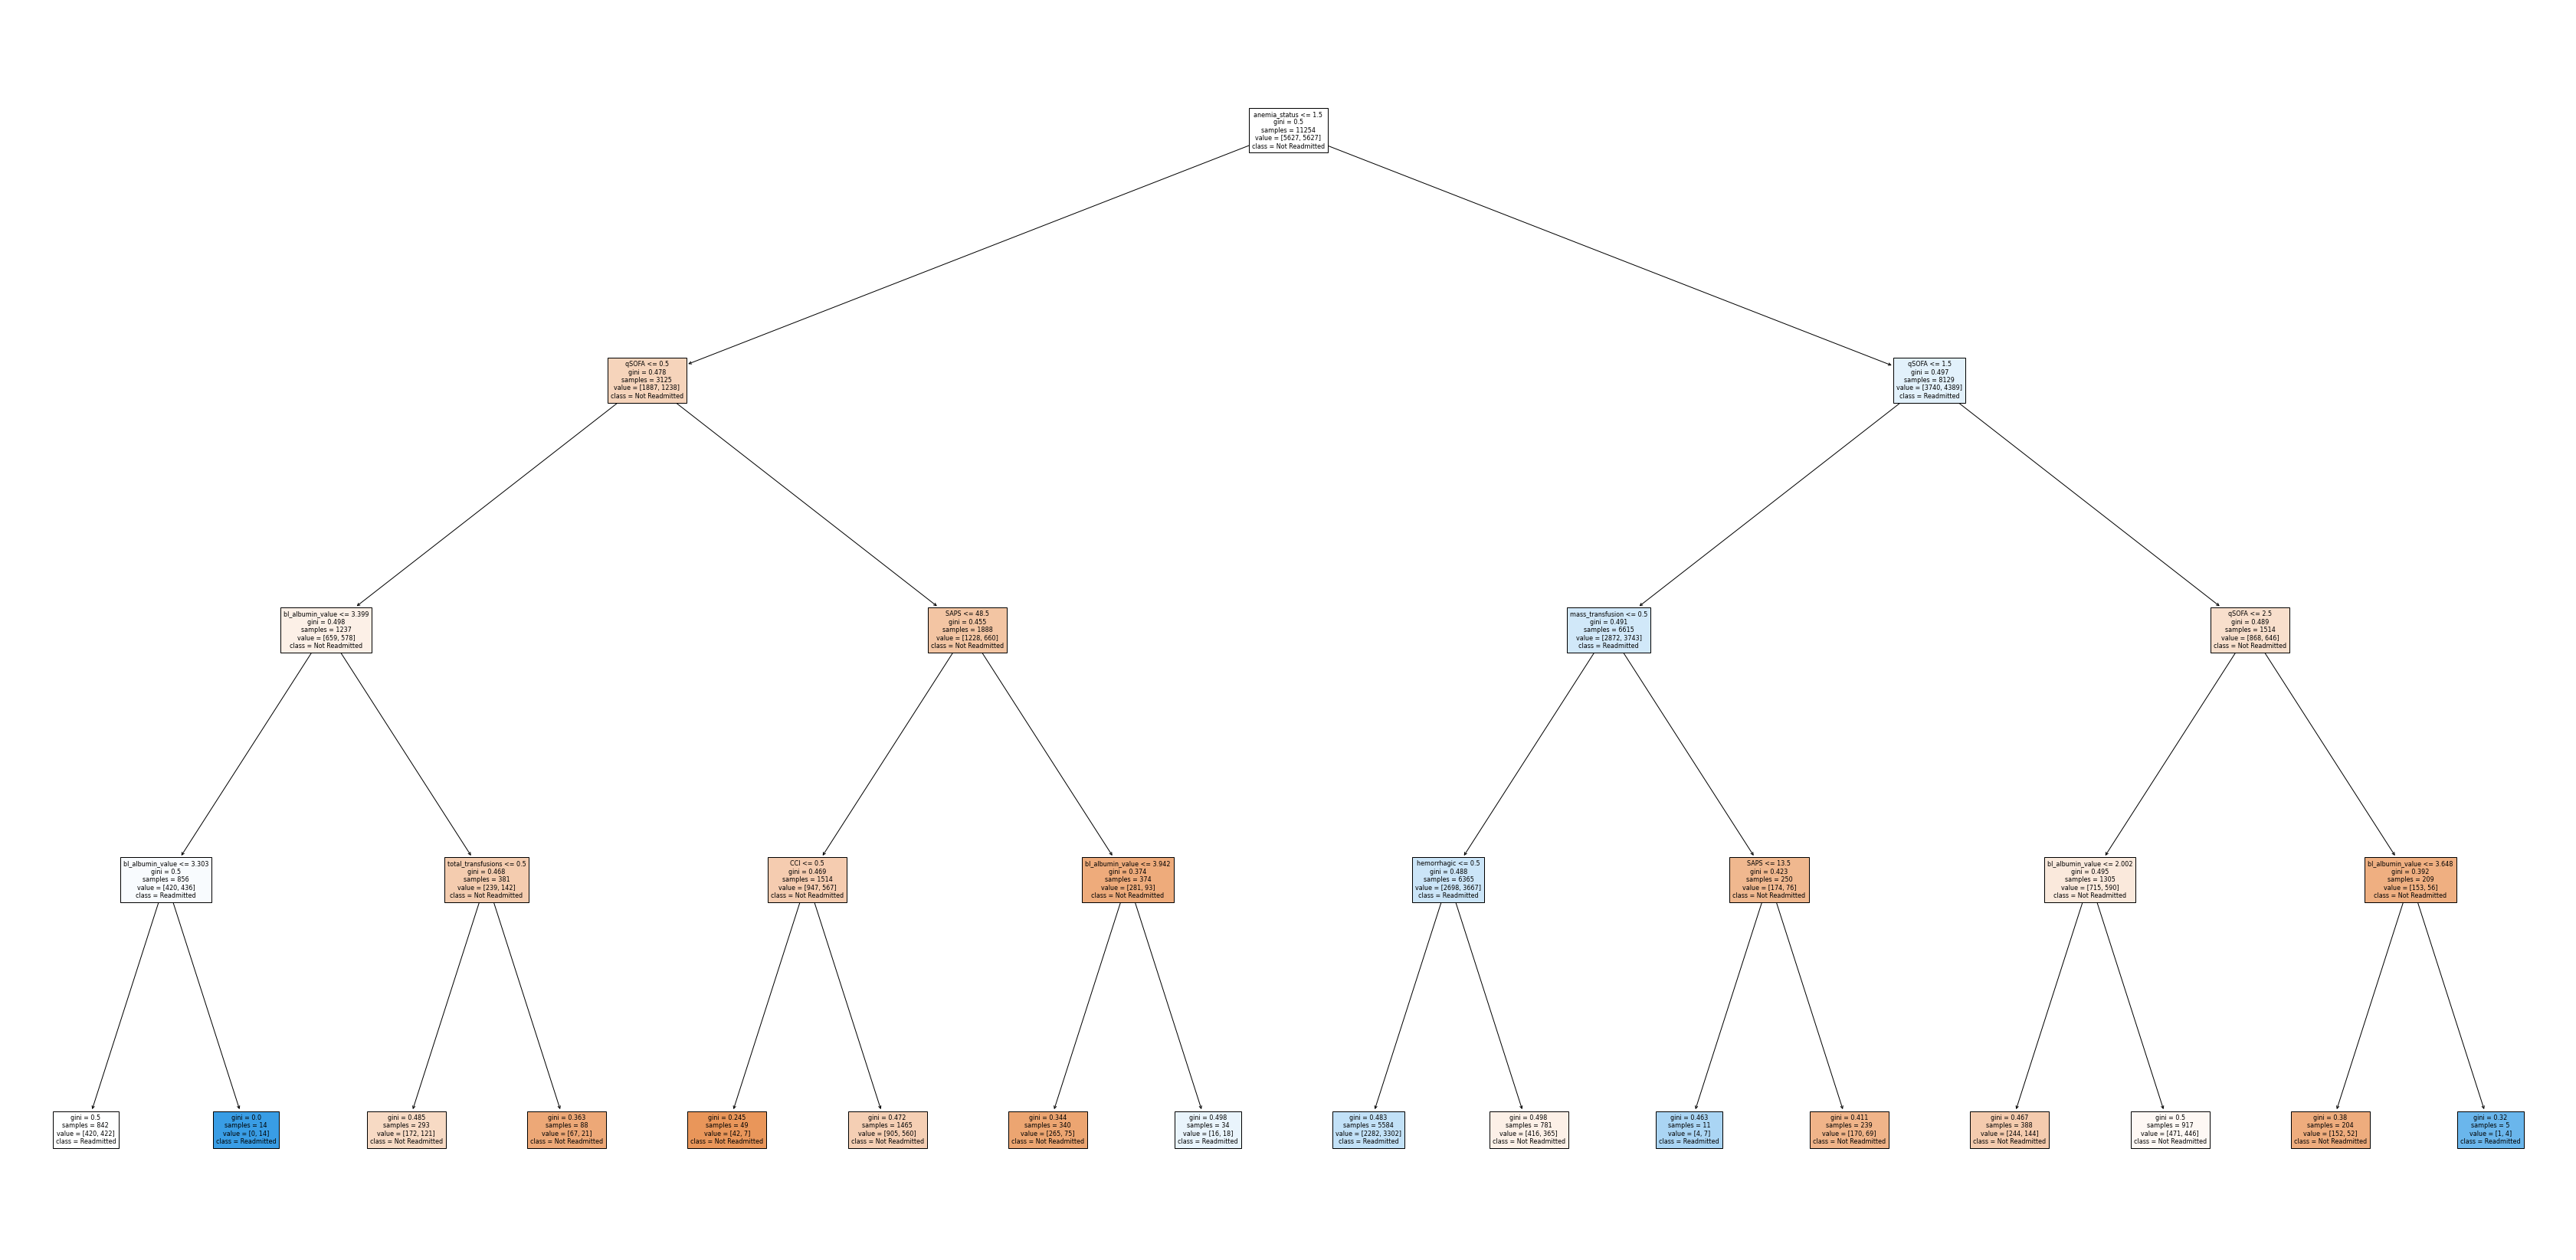

In [317]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [42]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('90DRA_DT_D4_NCBL.png')

True

## 3: Decision Tree 

In [318]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)

Feature: ICU Score: 0.00897
Feature: mass_transfusion Score: 0.11108
Feature: total_transfusions Score: 0.00000
Feature: anemia_status Score: 0.29090
Feature: CCI Score: 0.02077
Feature: bl_albumin_value Score: 0.08010
Feature: qSOFA Score: 0.26924
Feature: Cirrhosis Score: 0.00796
Feature: beta_blocker Score: 0.00801
Feature: hemorrhagic Score: 0.06568
Feature: SAPS Score: 0.12672
Feature: albumin_24hrs Score: 0.01056


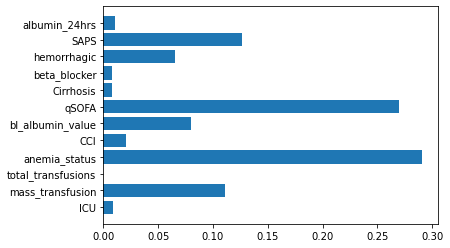

In [319]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [320]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [321]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3538 2089]
 [2406 3221]]


In [322]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.60      0.63      0.61      5627
           1       0.61      0.57      0.59      5627

    accuracy                           0.60     11254
   macro avg       0.60      0.60      0.60     11254
weighted avg       0.60      0.60      0.60     11254



In [323]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[864 535]
 [359 320]]


In [324]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66      1399
           1       0.37      0.47      0.42       679

    accuracy                           0.57      2078
   macro avg       0.54      0.54      0.54      2078
weighted avg       0.60      0.57      0.58      2078



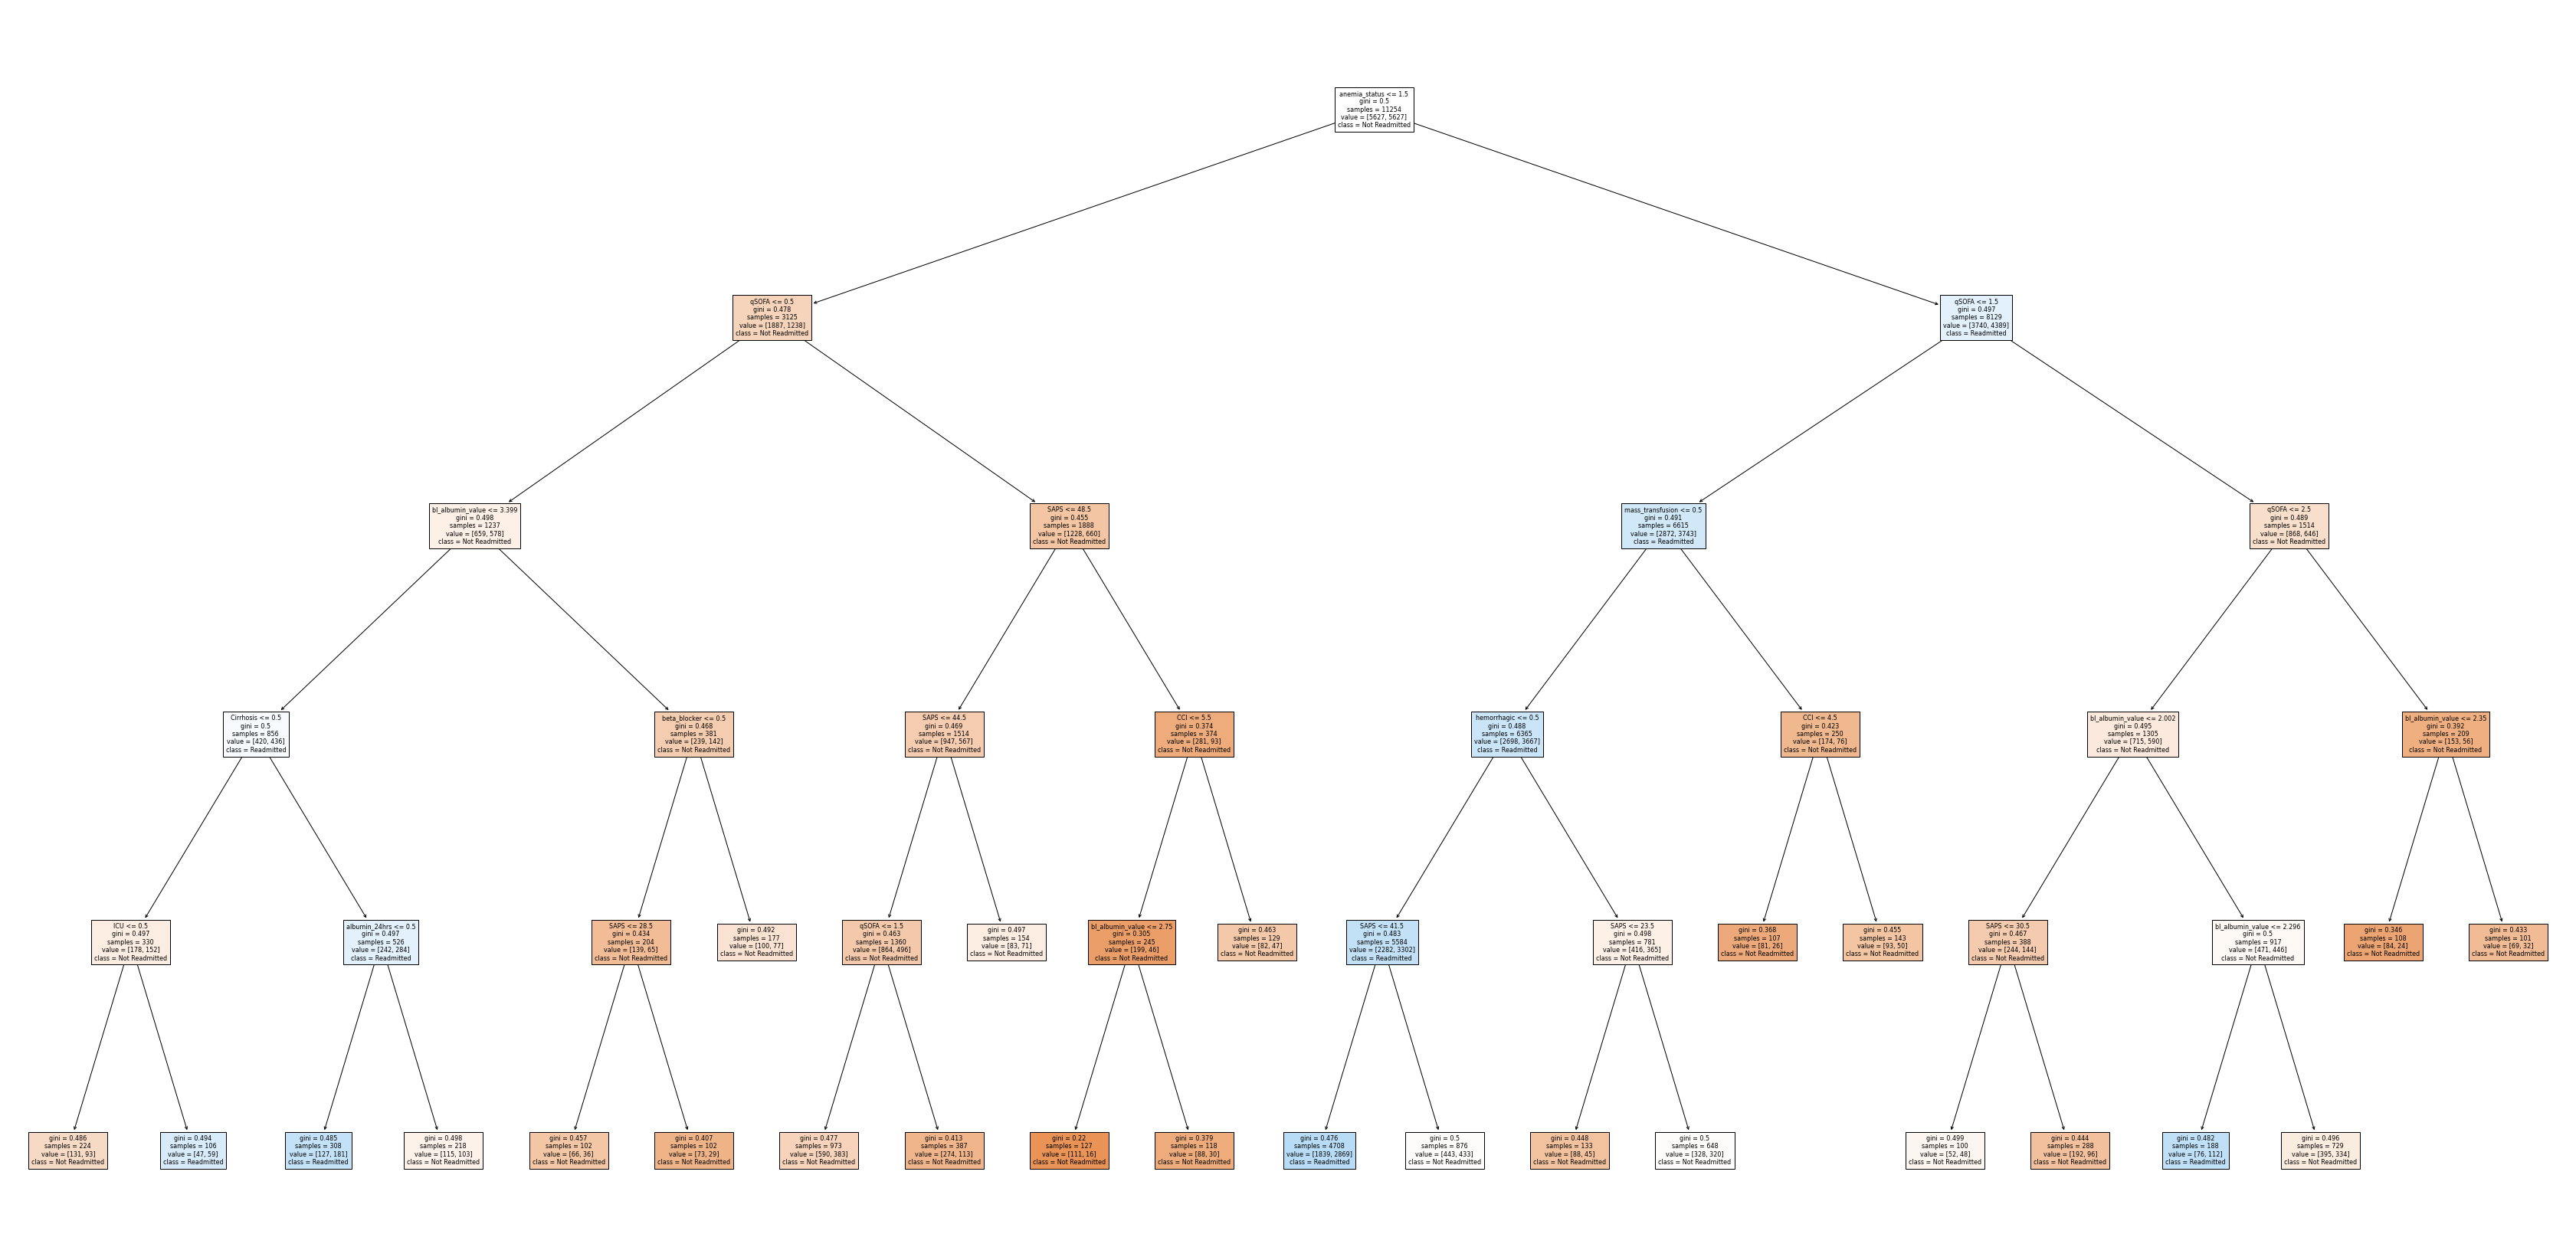

In [325]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [51]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DRA_DT_D5_NCBL.png')

True

## 4: Decision Tree 

In [326]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)

Feature: ICU Score: 0.03566
Feature: mass_transfusion Score: 0.09760
Feature: total_transfusions Score: 0.00653
Feature: anemia_status Score: 0.25898
Feature: CCI Score: 0.03170
Feature: bl_albumin_value Score: 0.12049
Feature: qSOFA Score: 0.23657
Feature: Cirrhosis Score: 0.00699
Feature: beta_blocker Score: 0.00704
Feature: hemorrhagic Score: 0.06582
Feature: SAPS Score: 0.11721
Feature: albumin_24hrs Score: 0.01541


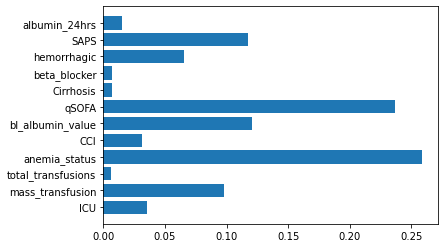

In [327]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [328]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [329]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3144 2483]
 [1918 3709]]


In [330]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.62      0.56      0.59      5627
           1       0.60      0.66      0.63      5627

    accuracy                           0.61     11254
   macro avg       0.61      0.61      0.61     11254
weighted avg       0.61      0.61      0.61     11254



In [331]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[745 654]
 [310 369]]


In [332]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.71      0.53      0.61      1399
           1       0.36      0.54      0.43       679

    accuracy                           0.54      2078
   macro avg       0.53      0.54      0.52      2078
weighted avg       0.59      0.54      0.55      2078



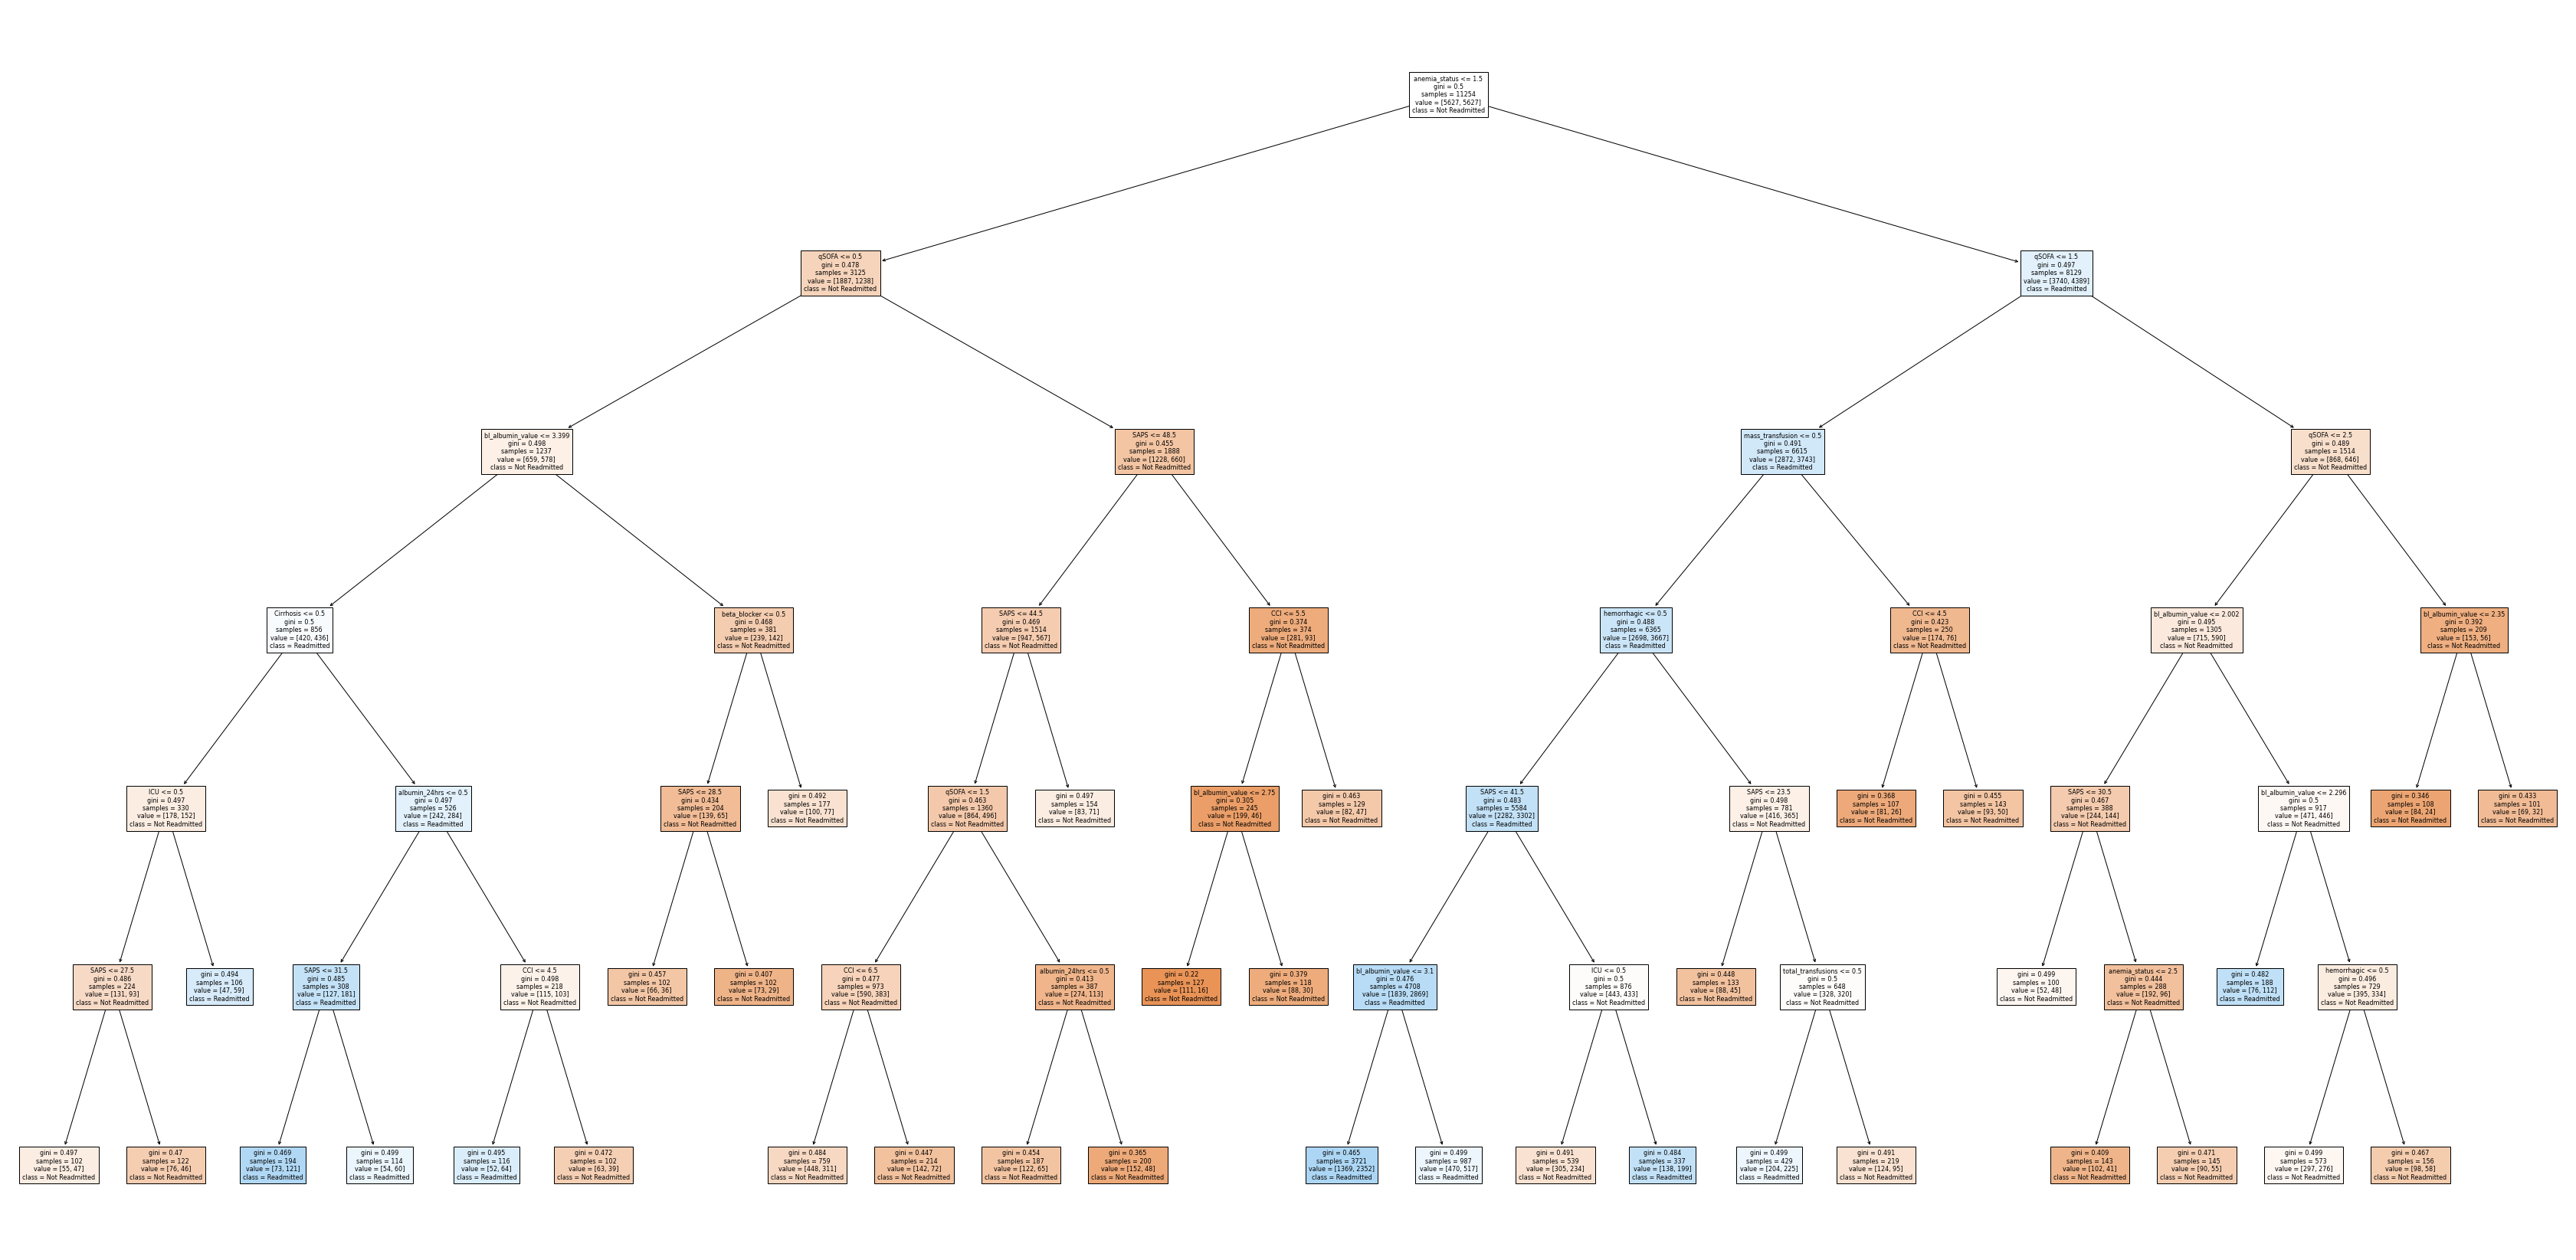

In [333]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [60]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DRA_DT_D6_NCBL.png')

True

## 5: Decision Tree 

In [92]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.10137
Feature: Cirrhosis Score: 0.05685
Feature: CCI Score: 0.11290
Feature: qSOFA Score: 0.26767
Feature: MELD Score: 0.36778
Feature: SEWS Score: 0.07597
Feature: albumin_24hrs Score: 0.01747


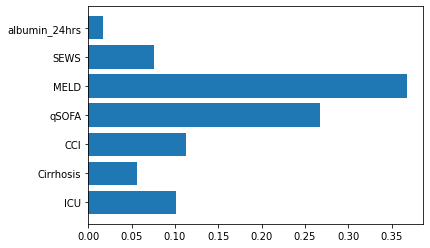

In [93]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [94]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [95]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2123 2677]
 [1466 3334]]


In [96]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.59      0.44      0.51      4800
         1.0       0.55      0.69      0.62      4800

    accuracy                           0.57      9600
   macro avg       0.57      0.57      0.56      9600
weighted avg       0.57      0.57      0.56      9600



In [97]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[534 663]
 [303 579]]


In [98]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.64      0.45      0.53      1197
         1.0       0.47      0.66      0.55       882

    accuracy                           0.54      2079
   macro avg       0.55      0.55      0.54      2079
weighted avg       0.57      0.54      0.53      2079



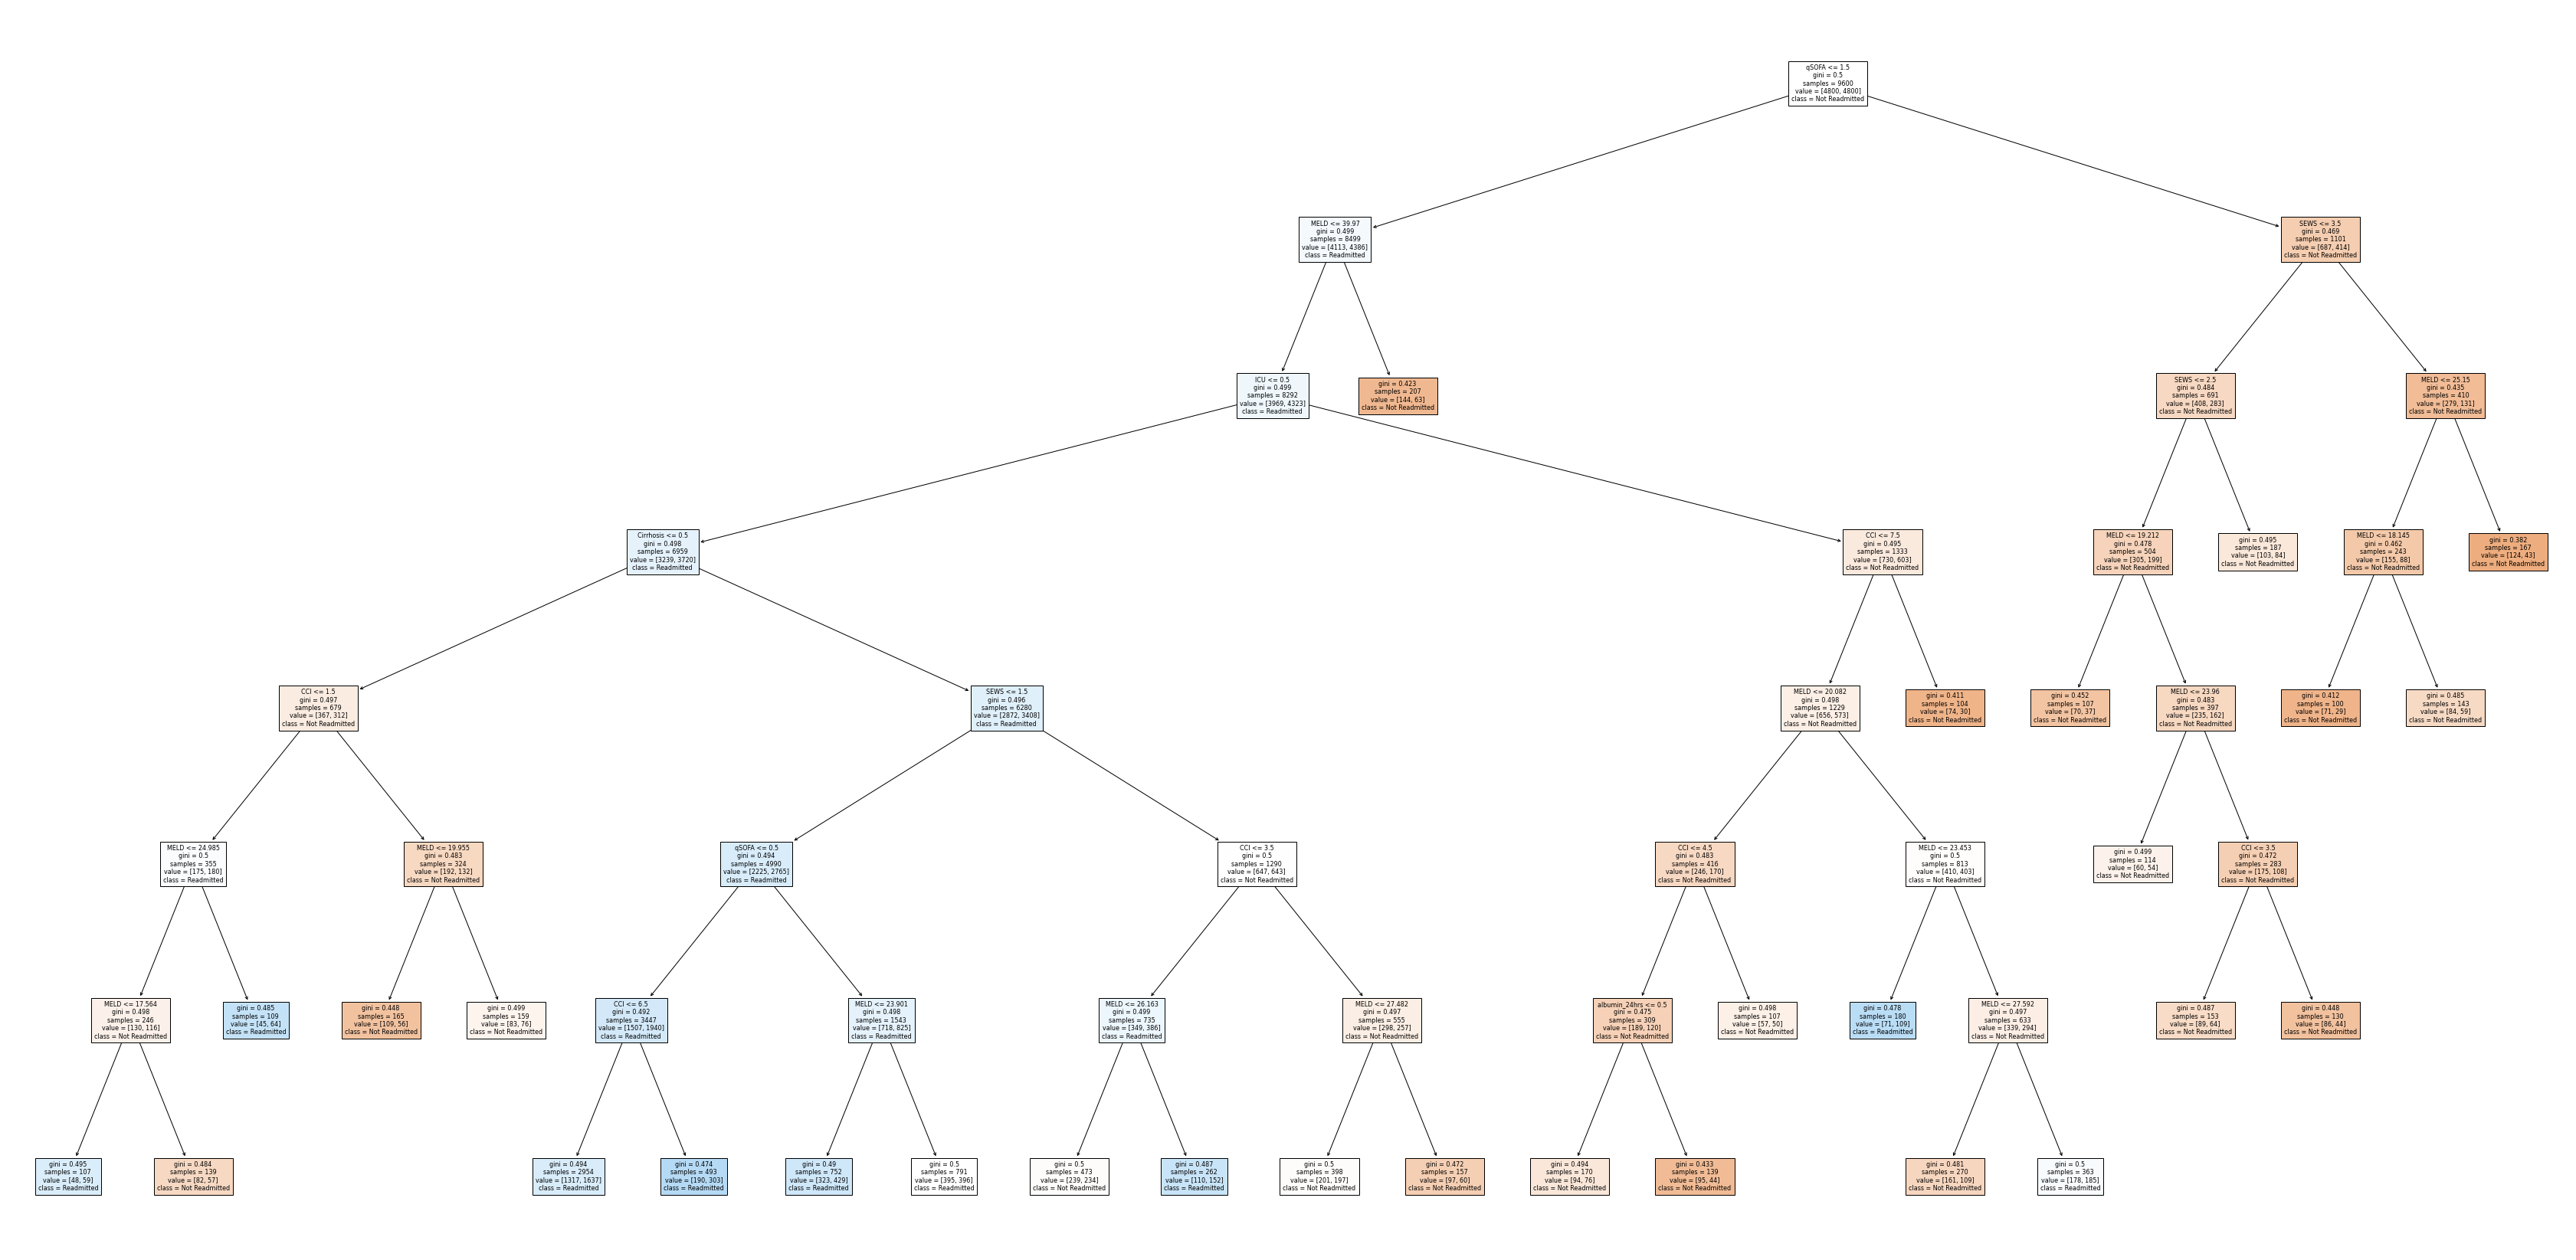

In [99]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [101]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DRA_DT_D7_PSM_MATCHED.png')

True

## 6: Decision Tree 

In [342]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=100)

Feature: ICU Score: 0.02855
Feature: mass_transfusion Score: 0.07814
Feature: total_transfusions Score: 0.00523
Feature: anemia_status Score: 0.23457
Feature: CCI Score: 0.03377
Feature: bl_albumin_value Score: 0.16639
Feature: qSOFA Score: 0.18940
Feature: Cirrhosis Score: 0.02734
Feature: beta_blocker Score: 0.02585
Feature: hemorrhagic Score: 0.05270
Feature: SAPS Score: 0.12075
Feature: albumin_24hrs Score: 0.03730


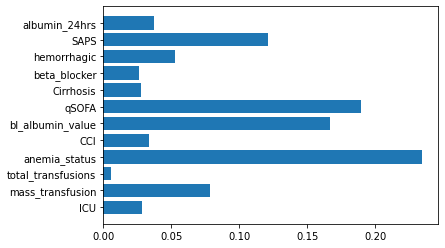

In [343]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [344]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [345]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3432 2195]
 [2032 3595]]


In [346]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      5627
           1       0.62      0.64      0.63      5627

    accuracy                           0.62     11254
   macro avg       0.62      0.62      0.62     11254
weighted avg       0.62      0.62      0.62     11254



In [347]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[823 576]
 [347 332]]


In [348]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.70      0.59      0.64      1399
           1       0.37      0.49      0.42       679

    accuracy                           0.56      2078
   macro avg       0.53      0.54      0.53      2078
weighted avg       0.59      0.56      0.57      2078



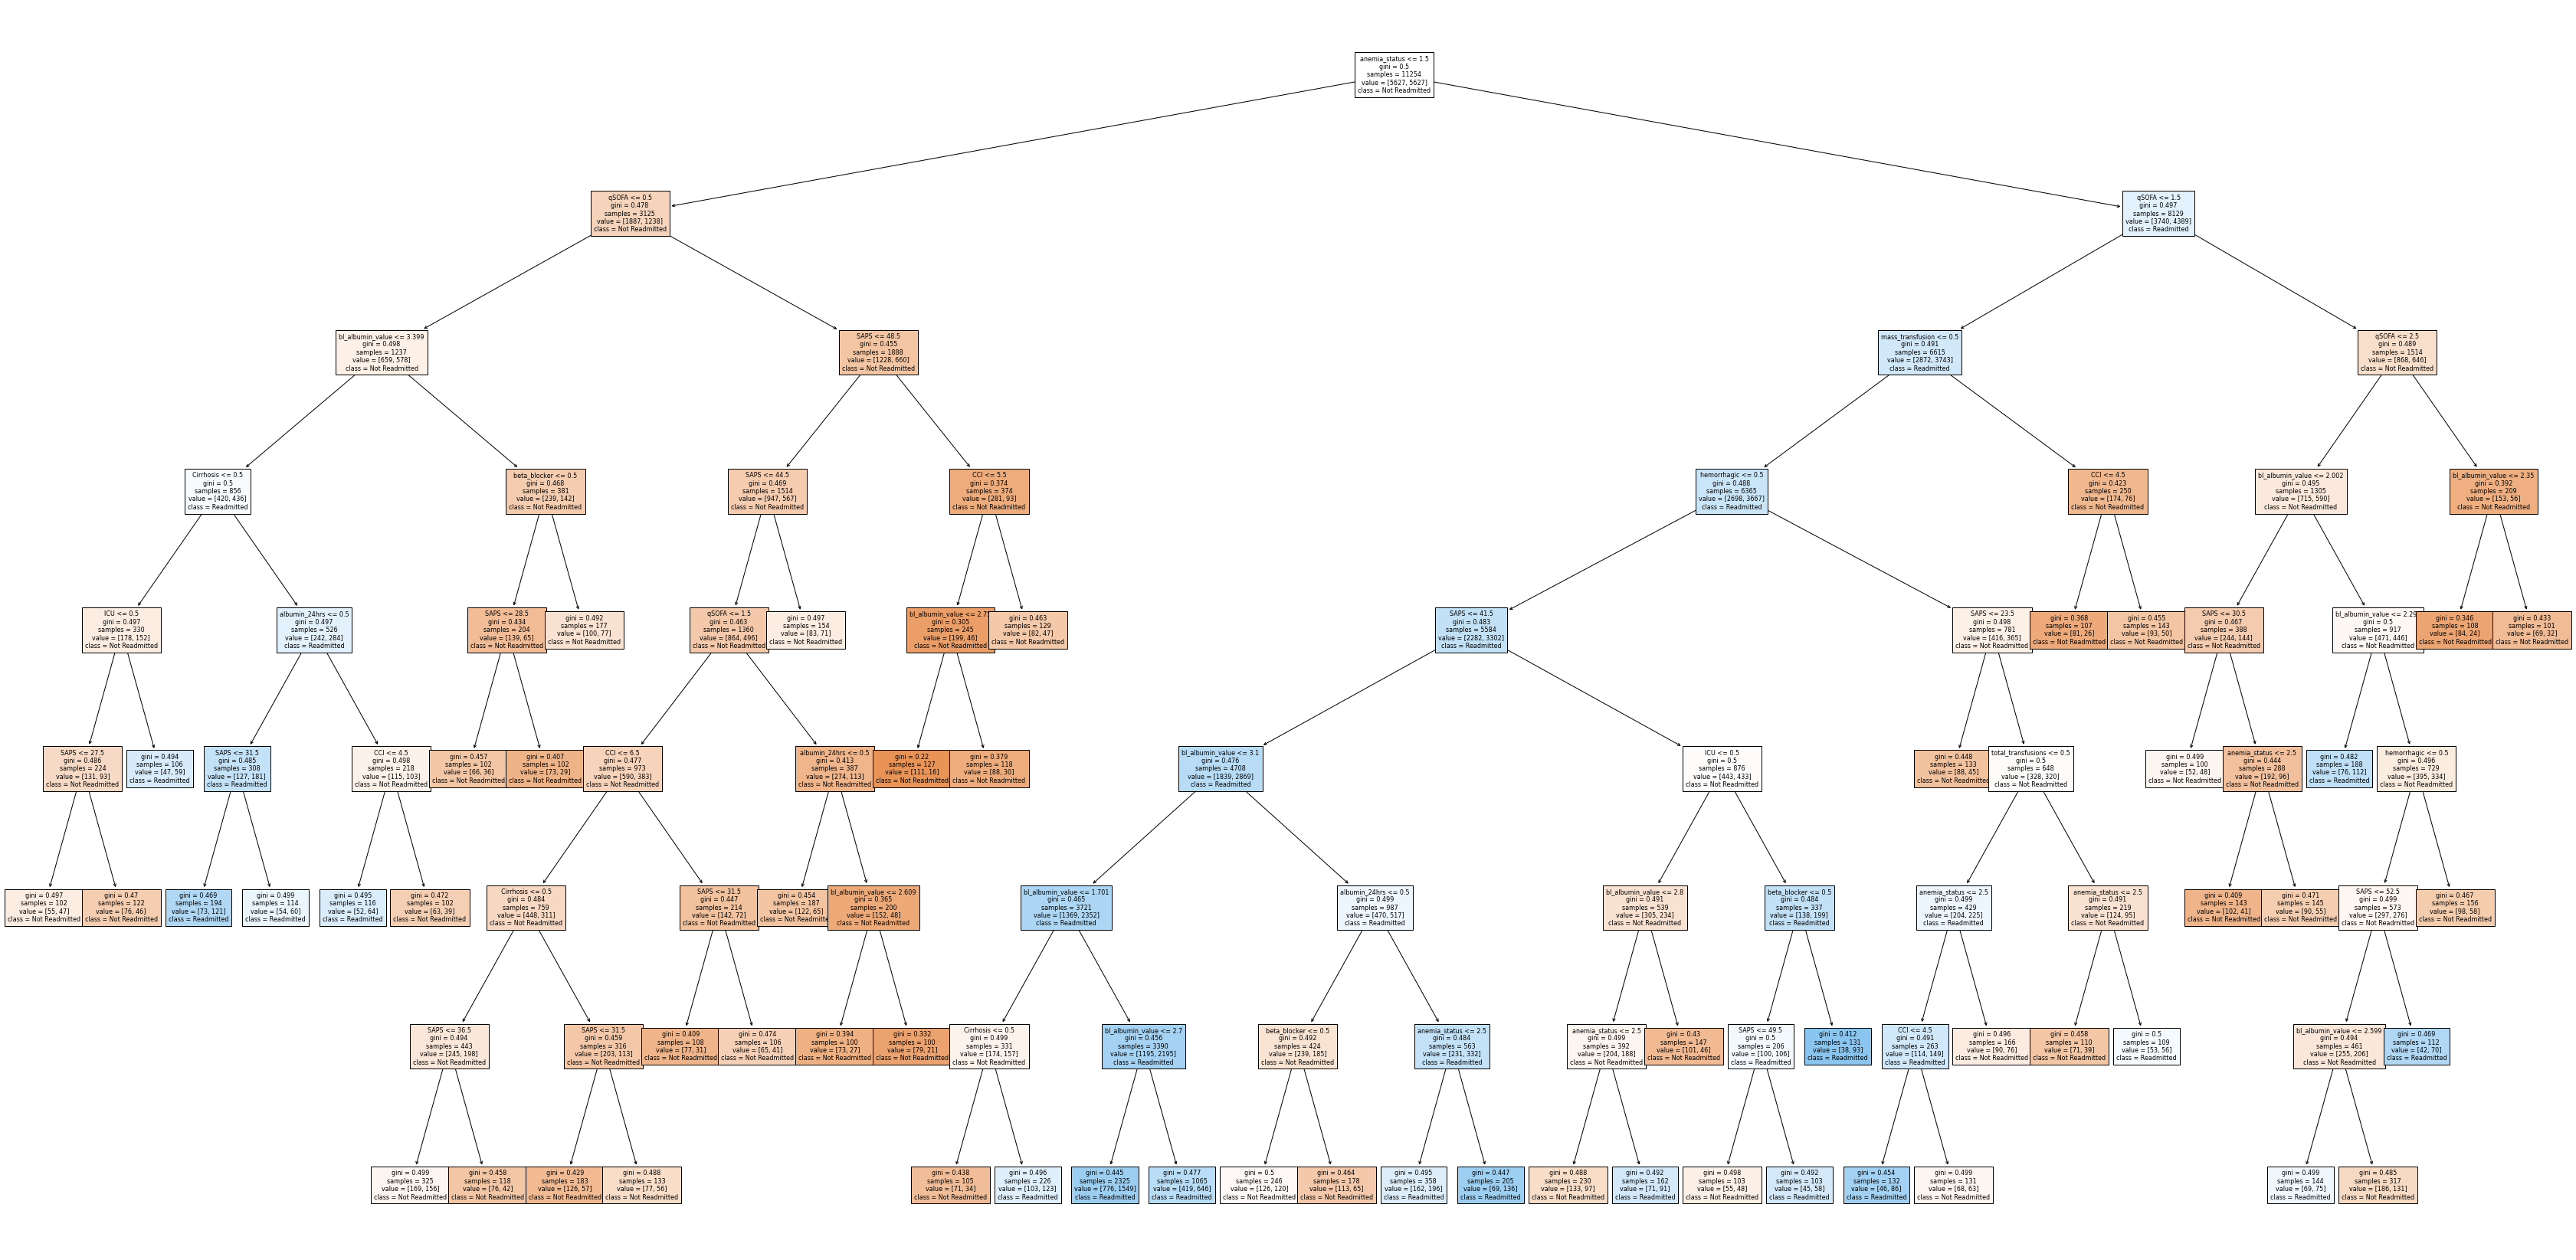

In [349]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [351]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DRA_DT_D8_NCBL_MATCHED.png')

True

## Random Forest

In [79]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [80]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [81]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[19668 14674]
 [14540 19802]]


In [82]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57     34342
           1       0.57      0.58      0.58     34342

    accuracy                           0.57     68684
   macro avg       0.57      0.57      0.57     68684
weighted avg       0.57      0.57      0.57     68684



In [83]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4861 3649]
 [1780 1932]]


In [84]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64      8510
           1       0.35      0.52      0.42      3712

    accuracy                           0.56     12222
   macro avg       0.54      0.55      0.53     12222
weighted avg       0.61      0.56      0.57     12222



Feature: anemia_status Score: 0.12464
Feature: CCI Score: 0.40683
Feature: albumin_24hrs Score: 0.04143
Feature: qSOFA Score: 0.05016
Feature: SAPS Score: 0.37694


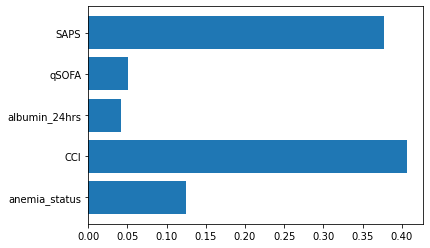

In [85]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()